# EMG WORD PREDICTION

### IMPORT NECESSARY MODULES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import glob
import pickle
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 300

from scipy import signal
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import librosa

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras

CURR_DIR = os.getcwd()

In [92]:

MAIN_DIR = os.path.join(CURR_DIR,"..","..")
DATA_DIR = os.path.join(MAIN_DIR,"dataset")
FILE_DIR = os.path.join(MAIN_DIR,"dataset","pickle")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
os.makedirs(FIG_DIR,exist_ok=True)

SPEAKER = ["RL","RN","SR","US"]
MODE = ["mentally","mouthed"]
WORDS = LABELS = ["add","call","go","later","left","reply","right","stop","subtract","you"]

SAMPLING_FREQ = 250 
NUM_CHANNELS = 8


# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIG_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [10]:
DATASET = os.listdir(FILE_DIR)
print(DATASET)

['RN_feature_time_me.pickle']


In [11]:

RN_feature_spectral_me = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))
RN_feature_spectral_mo = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))
RN_feature_time_me = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))
RN_feature_time_mo = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))
RN_feature_time_spectral_me = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))
RN_feature_time_spectral_me = pickle.load(open(os.path.join(FILE_DIR,DATASET[0]),"rb"))

In [13]:
RN_feature_time_me.keys()

dict_keys(['data', 'label'])

In [58]:
X = RN_feature_time_me["data"]
Y = RN_feature_time_me["label"]

In [59]:
print(X.shape)
print(Y.shape)

(371, 1209, 40)
(371,)


In [70]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y_1hot = tf.keras.utils.to_categorical(Y, num_classes = 10)
print(encoder.classes_)
print("Encoded labels (normal): \n",Y[0:5])
print("Encoded labels (ONE-HOT): \n",Y_1hot[0:5])

['add' 'call' 'go' 'later' 'left' 'reply' 'right' 'stop' 'subtract' 'you']
Encoded labels (normal): 
 [1 1 1 1 1]
Encoded labels (ONE-HOT): 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [27]:
def train_test_split(X,Y):
    split = StratifiedShuffleSplit(n_splits=1, test_size =0.1, random_state=42)
    train_id, test_id = next(split.split(X,Y))
    return np.array([X[n] for n in train_id]), np.array([Y[n] for n in train_id]), np.array([X[n] for n in test_id]),np.array([Y[n] for n in test_id])

In [50]:

X_MLP = np.array([x.flatten() for x in X])
print("Raw feature shape: ",X_MLP.shape)

Raw feature shape:  (371, 100)


In [51]:
reducer = FastICA(n_components=100,random_state=42)
X_MLP = reducer.fit_transform(X_MLP)

In [97]:
X_train,Y_train,X_test,Y_test = train_test_split(X_MLP,Y)

print("Train Set Shape of X: ",X_train.shape)
print("Test Set Shape of X: ",X_test.shape)

print("Train Set Shape of Y: ",Y_train.shape)
print("Test Set Shape of Y: ",Y_test.shape)

Train Set Shape of X:  (333, 100)
Test Set Shape of X:  (38, 100)
Train Set Shape of Y:  (333,)
Test Set Shape of Y:  (38,)


In [98]:
def MLP_Classifier(X_train,Y_train,X_test,Y_test):
    MLP_model = keras.Sequential()
    MLP_model.add(keras.layers.Dense(units=200,activation="relu",input_shape=X_train[0].shape))
    MLP_model.add(keras.layers.Dropout(0.5))
    MLP_model.add(keras.layers.Dense(64,activation="relu"))
    MLP_model.add(keras.layers.Dense(64,activation="relu"))
    MLP_model.add(keras.layers.Dropout(0.5))
    MLP_model.add(keras.layers.Dense(10,activation="softmax"))
    print(MLP_model.summary())
    optimizer=keras.optimizers.Adam()
    MLP_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    history = MLP_model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=1)    
    MLP_prediction = np.array(list(map(np.argmax,MLP_model.predict(X_test))))
    return Y_test,MLP_prediction

In [99]:
a,b = MLP_Classifier(X_train,Y_train,X_test,Y_test)
c,d = MLP_Classifier(X_train,Y_train,X_test,Y_test)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                650       
Total params: 37,874
Trainable params: 37,874
Non-trainable params: 0
_________________________________________________

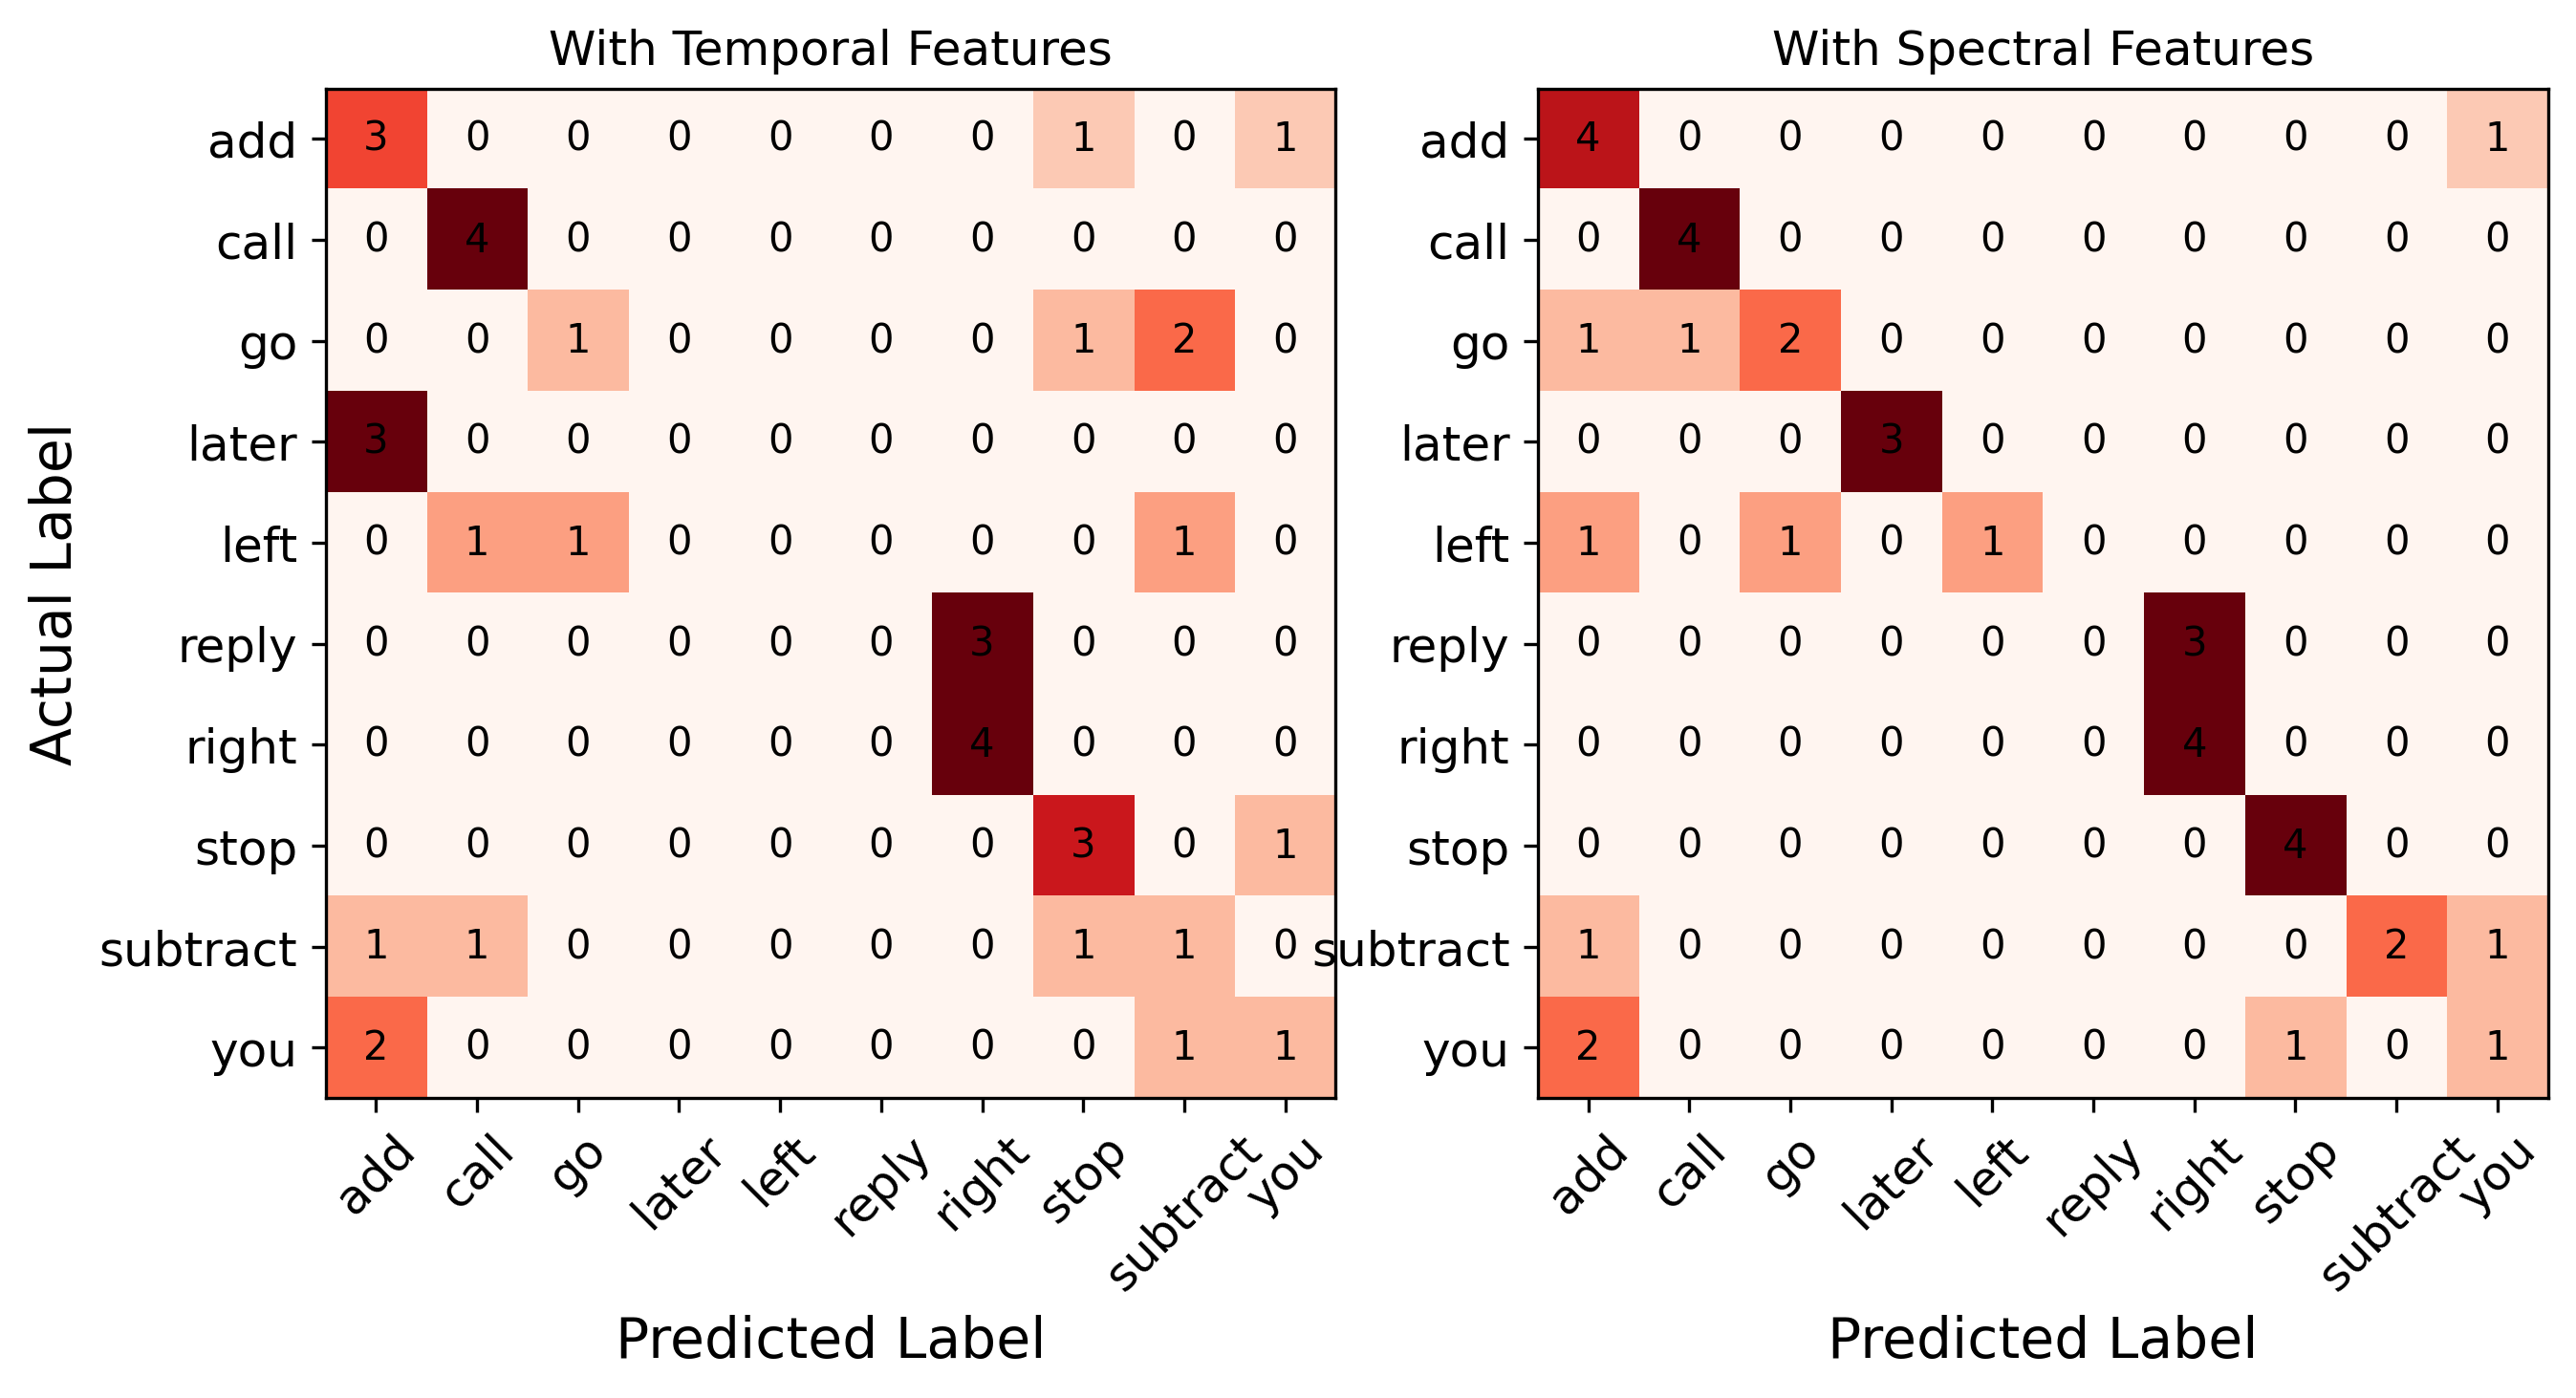

In [100]:
plotCM(a,b.flatten(),c,d.flatten())

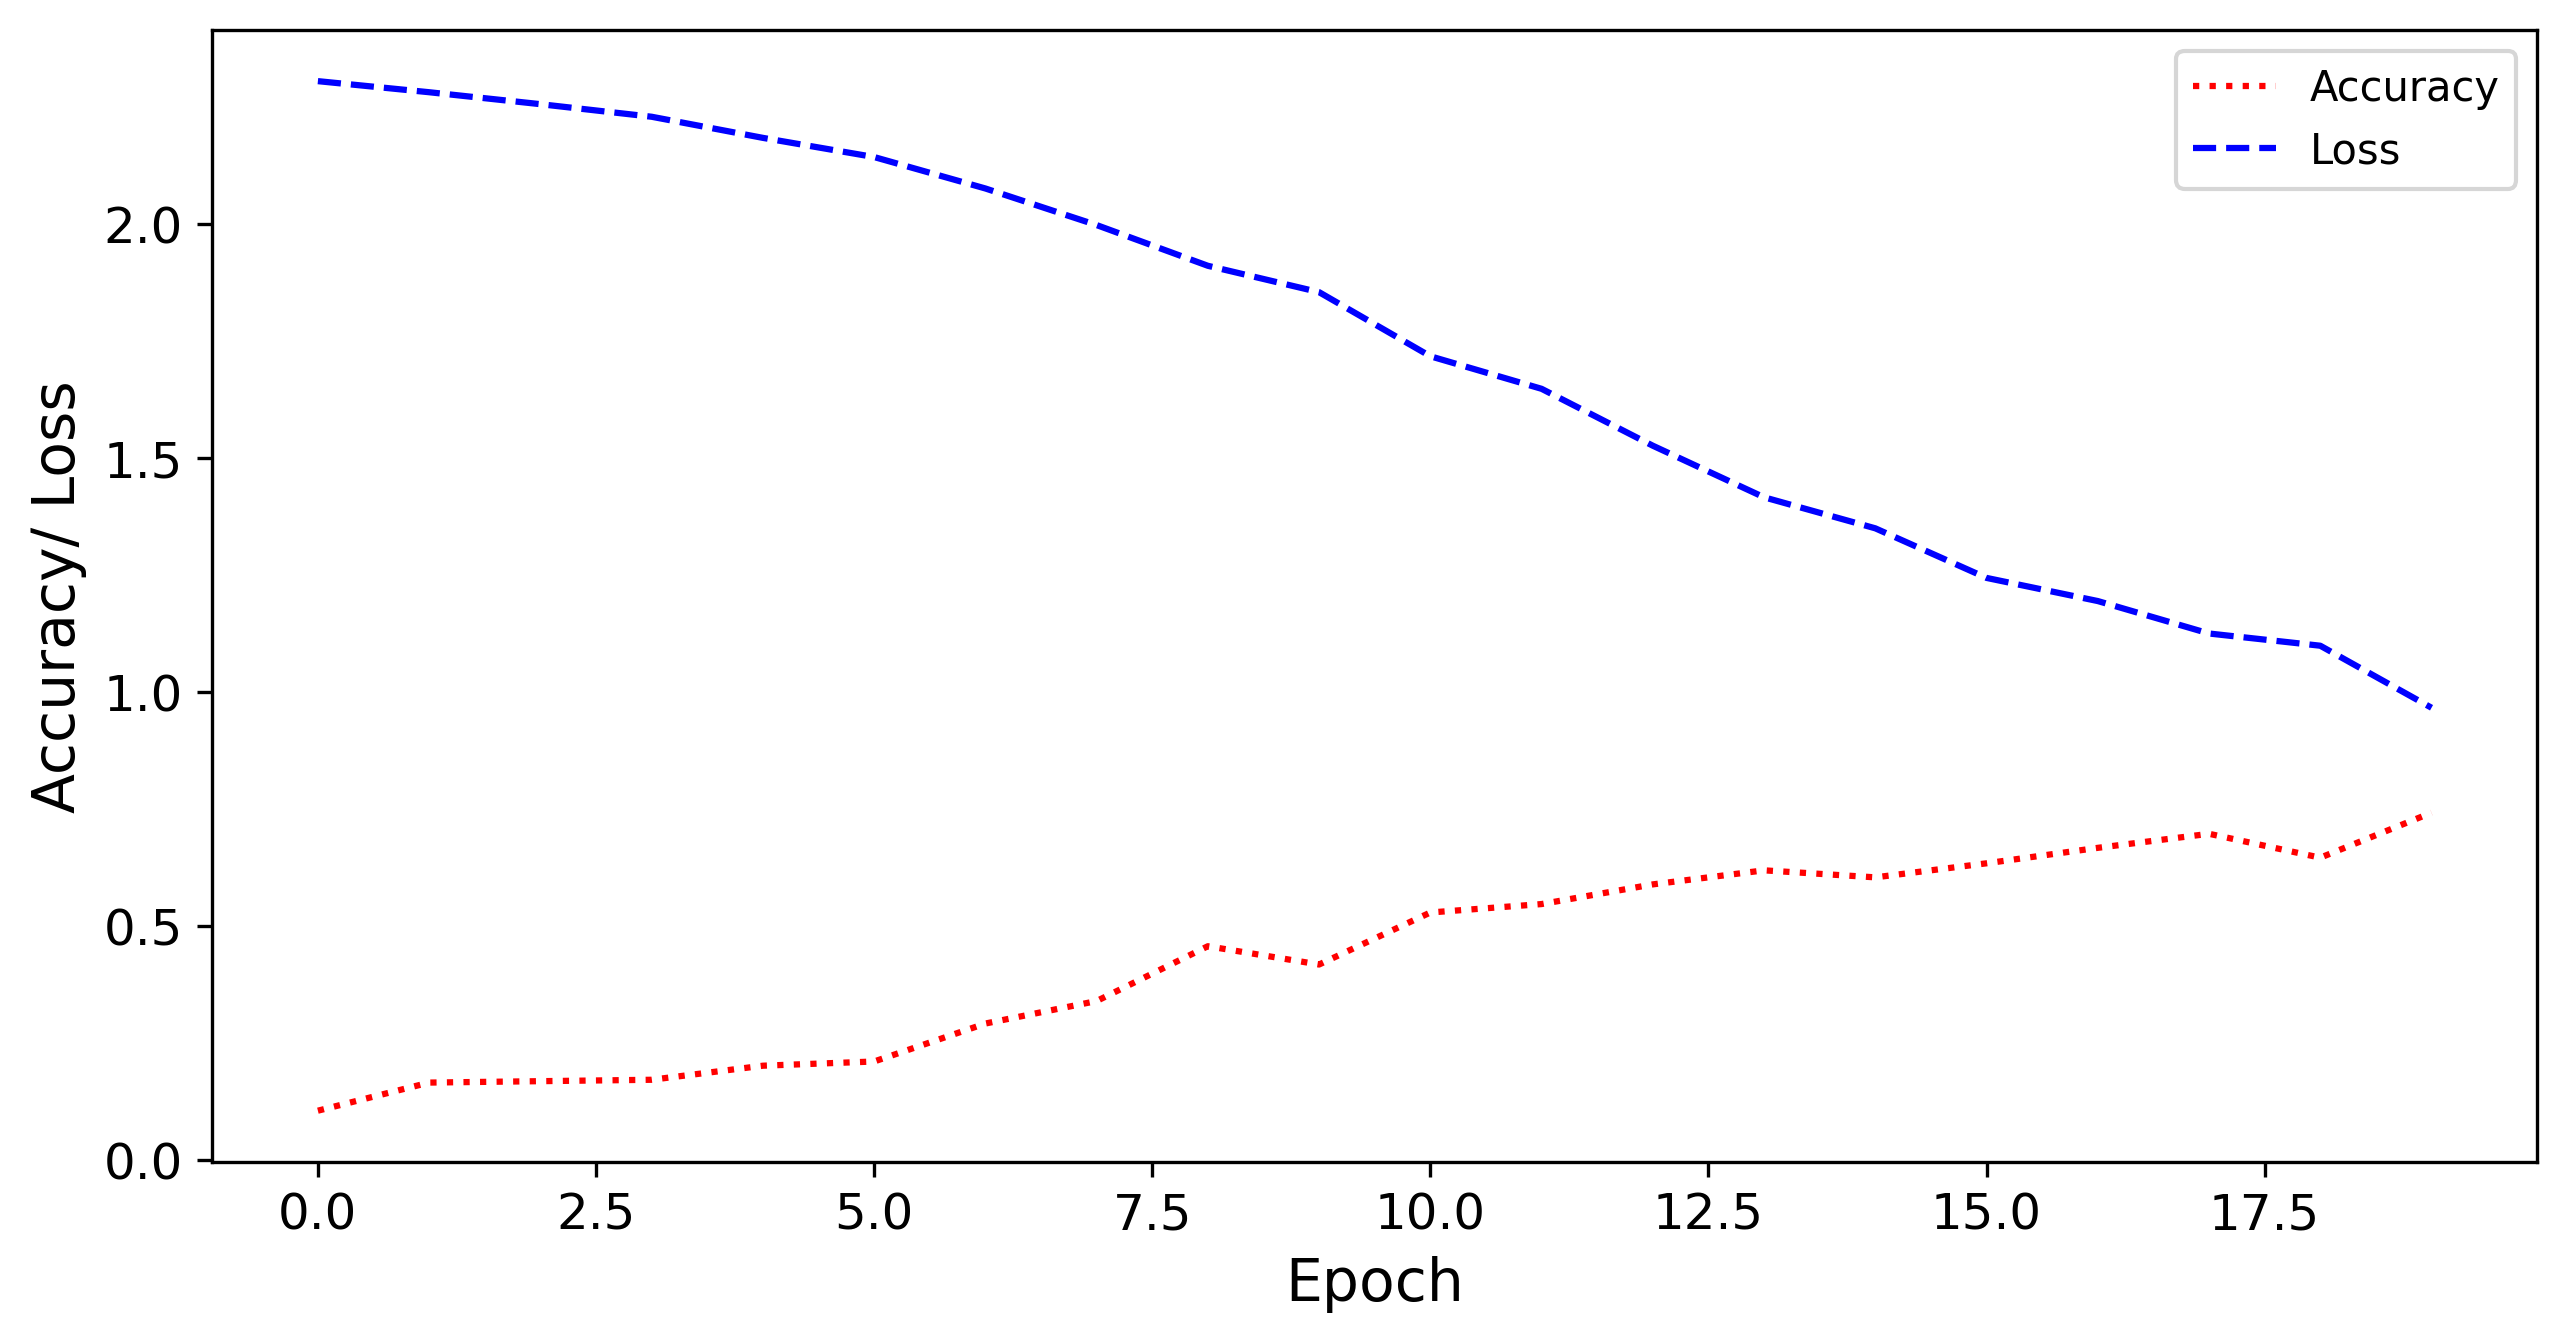

In [56]:
plt.plot(history.history["accuracy"],"r:")
plt.plot(history.history["loss"],"b--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/ Loss")
plt.legend(["Accuracy","Loss"])
# save_fig("ACC_LOSS_US_FIltered")

In [68]:
from copy import deepcopy

X_CNN = deepcopy(X)

print(X_CNN.shape)

(371, 1209, 40)


In [71]:
X_train,Y_train,X_test,Y_test = train_test_split(X_CNN,Y)
print("Train Set Shape: ",X_train.shape)
print("Test Set Shape: ",X_test.shape)

print("Train Set Shape: ",Y_train.shape)
print("Test Set Shape: ",Y_test.shape)

Train Set Shape:  (333, 1209, 40)
Test Set Shape:  (38, 1209, 40)
Train Set Shape:  (333,)
Test Set Shape:  (38,)


In [72]:
Y_train = (Y_train.reshape(-1,len(Y_train))).T
Y_test = (Y_test.reshape(-1,len(Y_test))).T

print("Train Set Shape: ",X_train.shape)
print("Test Set Shape: ",X_test.shape)

print("Train Set Shape: ",Y_train.shape)
print("Test Set Shape: ",Y_test.shape)

Train Set Shape:  (333, 1209, 40)
Test Set Shape:  (38, 1209, 40)
Train Set Shape:  (333, 1)
Test Set Shape:  (38, 1)


In [93]:
def plotCM(y, predictions,y2,predictions2):
    cm = confusion_matrix(y, predictions)
#     print(cm)
#     plt.suptitle("KNN\n\n")
    plt.subplot(121)
    plt.title("With Temporal Features")
    plt.imshow(confusion_matrix(y, predictions,normalize="true"), interpolation = 'nearest',cmap = plt.cm.Reds)
    plt.xticks(range(len(LABELS)), LABELS, rotation = 45)
    plt.yticks(range(len(LABELS)), LABELS)
    
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

    for i in range(10):
        for j in range(10):
            plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
   

    plt.subplot(122)
    plt.title("With Spectral Features")
    plt.imshow(confusion_matrix(y2, predictions2,normalize="true"), interpolation = 'nearest',cmap = plt.cm.Reds)
    plt.xticks(range(len(LABELS)), LABELS, rotation = 45)
    plt.yticks(range(len(LABELS)), LABELS)
    
#     plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    cm = confusion_matrix(y2, predictions2)
    
    for i in range(10):
        for j in range(10):
            plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
#     save_fig("CNN_CM_DOUBLE-Silent")
    plt.show()

In [89]:
def CNN_Classifier(X_train,Y_train,X_test,Y_test,PLOTS=False):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
    CNN_model = keras.Sequential()
    CNN_model.add(keras.layers.Conv1D(100, kernel_size = 12, input_shape =(n_timesteps,n_features), activation = "relu"))
    # 	CNN_model.add(keras.layers.Conv1D(100, kernel_size = 12, input_shape = X_train.shape[1:], activation = "relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Conv1D(100,kernel_size=6,activation="relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Flatten())
    CNN_model.add(keras.layers.Dense(100,activation="relu"))
    CNN_model.add(keras.layers.Dense(10,activation="softmax"))

    opt = keras.optimizers.Adam(lr = 0.0001)

    CNN_model.compile(optimizer = opt, loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    print(CNN_model.summary())
    history = CNN_model.fit(X_train, Y_train, epochs = 5, batch_size = 50, validation_data =(X_test, Y_test) ,verbose = 1)
    CNN_prediction = np.array(list(map(np.argmax,CNN_model.predict(X_test))))
    
    if(PLOTS=True):
        plt.plot(history.history["accuracy"],"r:")
        plt.plot(history.history["loss"],"b--")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy/ Loss")
        plt.legend(["Accuracy","Loss"])
        # save_fig("ACC_LOSS_US_FIltered")
    
    
    return Y_test,CNN_prediction

In [90]:
a,b = CNN_Classifier(X_train,Y_train,X_test,Y_test)
c,d = CNN_Classifier(X_train,Y_train,X_test,Y_test)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1198, 100)         48100     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 599, 100)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 594, 100)          60100     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 297, 100)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 29700)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               2970100   
_________________________________________________________________
dense_28 (Dense)             (None, 10)              

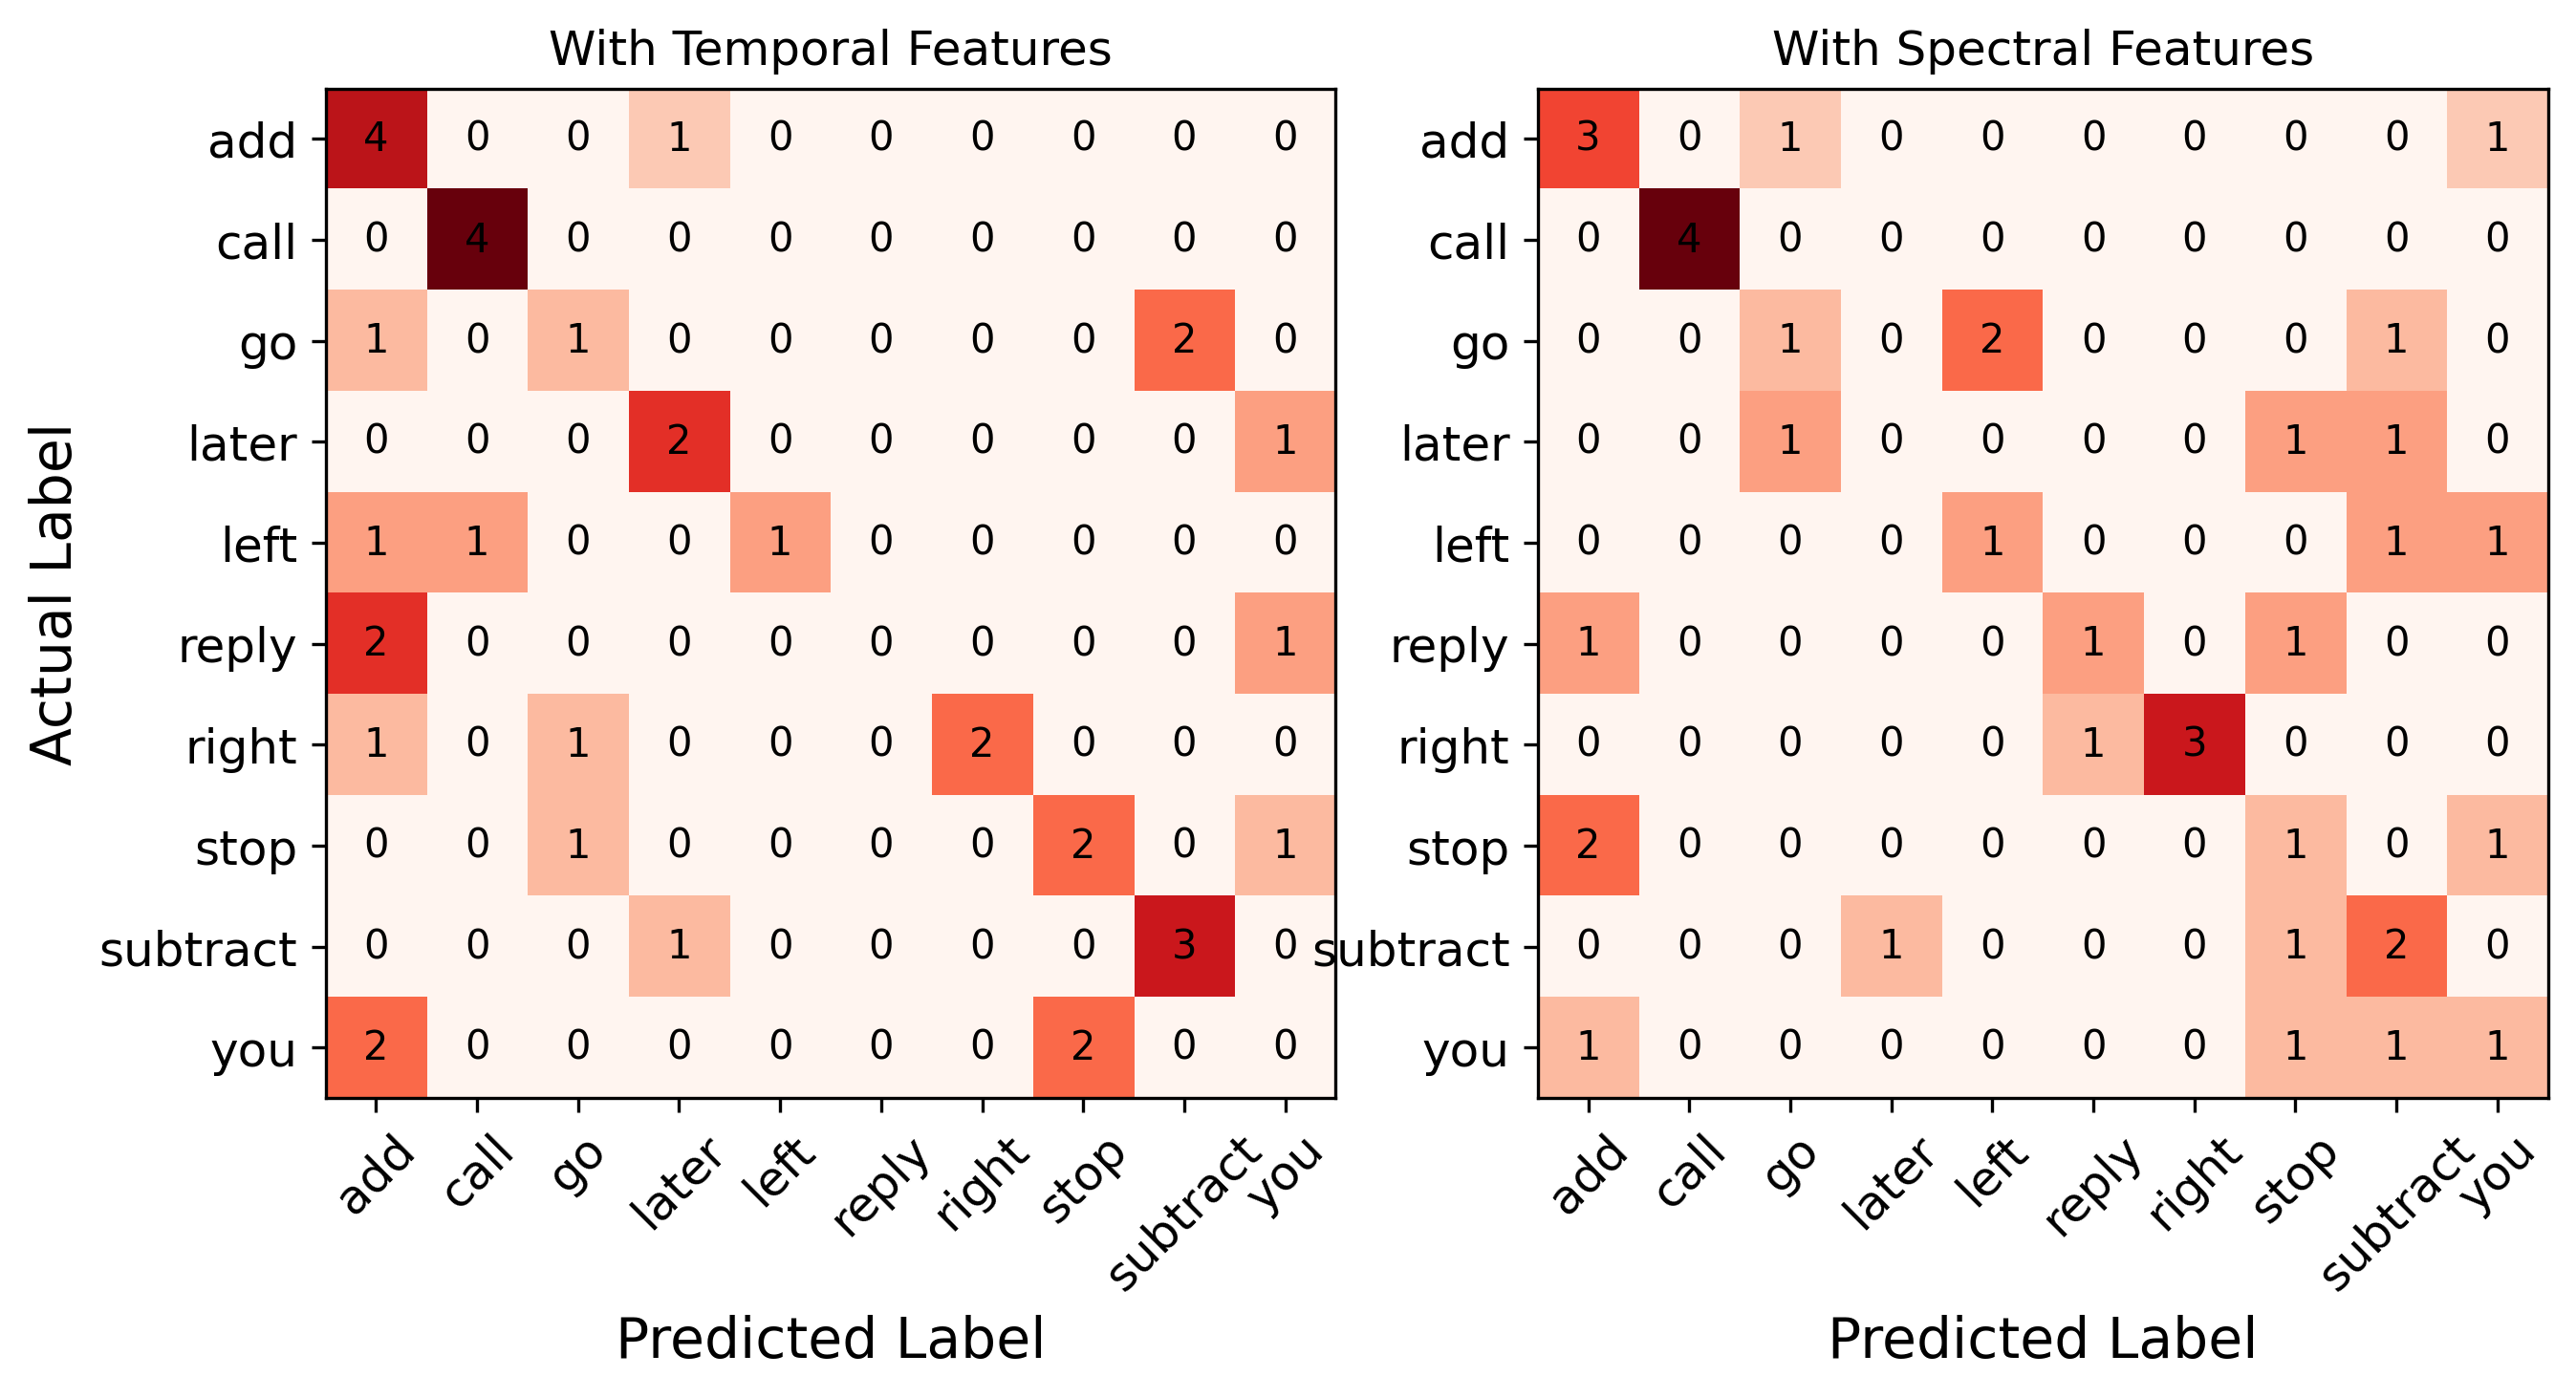

In [94]:
plotCM(a,b.flatten(),c,d.flatten())
# print(b.flatten())